# Proyecto 2 MDD
Por Sebastián Bustamante.

Esta primera parte del proyecto se centra en limpiar el dataset

dataset en kaggle: https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [1]:
# Importando los modulos a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, make_scorer, confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import svm

In [2]:
df = pd.read_csv("set_Sebastian_Bustamante.csv")
df.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

Funcion auxiliar, calcular "manualmente" TP, FP y global accuracy

In [3]:
def get_tp_fp(y_test, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for val_test, val_pred in zip(y_test, y_pred):
        if val_test == 0 and val_pred == 0:
            tp = tp + 1
        elif val_test == 1 and val_pred == 0:
            fp = fp + 1
        elif val_test == 1 and val_pred == 1:
            tn = tn + 1
        elif val_test == 0 and val_pred == 1:
            fn = fn + 1
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(tn+fp)
    fn_rate = fn/(fn+tp)
    fp_rate = fp/(fp+tn)
    ga = (tp+tn)/(tp+tn+fp+fn)
    prec = (tp)/(tp+fp)

    return tp_rate, fp_rate, tn_rate, fn_rate, ga, prec

In [4]:
def cross_report(cross_list):
    fps = []
    tps = []
    tns = []
    fns = []
    gas = []
    precs = []
    for dic in cross_list:
        fps.append(dic["fp_rate"])
        tps.append(dic["tp_rate"])
        tns.append(dic["tn_rate"])
        fns.append(dic["fn_rate"])
        precs.append(dic["prec"])
        gas.append(dic["ga"])

    return {
            "Global Accuracy avg": np.average(gas),
            "Global Accuracy stdev": np.std(gas),
            "True positive rate avg":np.average(tps),
            "True positive rate stdev": np.std(tps),
            "True negative rate avg": np.average(tns),
            "True negative rate stdev": np.std(tns),
            "False positive rate avg": np.average(fps),
            "False positive rate stdev": np.std(fps),
            "False negative rate avg": np.average(fns),
            "False negative rate stdev": np.std(fns),
            "Precision avg": np.average(precs),
            "Precision stdev": np.std(precs),
            }

In [5]:
def process_metrics(metrics_dict):
    processed_data = {}

    # Iterate through the dictionary and format the strings
    for key, value in metrics_dict.items():
        if 'avg' in key:
            metric_name = key.replace(' avg', '')
            avg = value
            stdev = metrics_dict.get(f'{metric_name} stdev', None)
            if stdev is not None:
                formatted_string = f'{avg:.4f} ± {stdev:.4f}'
                processed_data[metric_name] = formatted_string
    
    return processed_data

In [6]:
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def true_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def precision(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fp)

def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

def true_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

## Empezar con la limpieza del dataset

Eliminar la columna del ID

In [7]:
df = df.drop('Booking_ID', axis = 1)

Pasar las variables categóricas a numéricas

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder_type_of_meal_plan = LabelEncoder()
label_encoder_room_type_reserved = LabelEncoder()
label_encoder_market_segment_type = LabelEncoder()
label_encoder_booking_status = LabelEncoder()

df['type_of_meal_plan'] = label_encoder_type_of_meal_plan.fit_transform(df['type_of_meal_plan'])
df['room_type_reserved'] = label_encoder_room_type_reserved.fit_transform(df['room_type_reserved'])
df['market_segment_type'] = label_encoder_market_segment_type.fit_transform(df['market_segment_type'])
df['booking_status'] = label_encoder_booking_status.fit_transform(df['booking_status'])

In [9]:
le_name_mapping = dict(zip(label_encoder_booking_status.classes_, label_encoder_booking_status.transform(label_encoder_booking_status.classes_)))
print(le_name_mapping)

{'Canceled': 0, 'Not_Canceled': 1}


Separar la variable objetivo de las demás

In [10]:
X = df.drop('booking_status', axis = 1)
X = X.values
y = df['booking_status']

Naive Bayes sin balancear las clases, para comparar el desempeño balanceado del no balanceado y ver si existe el problema.

De todas formas se escala toda la data:

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

Luego generar los conjuntos de entrenamiento y prueba:

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Generar datos sin balancear para probar naive bayes

In [13]:
moredata = []
for i in range(10):
    X_train_temp,X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y, test_size = 0.2, random_state = i)
    moredata.append({"X_train": X_train_temp, "X_test": X_test_temp, "y_train": y_train_temp, "y_test": y_test_temp})

Ahora probar Naive Bayes Gausiano, sin balancear

In [14]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
previsoes = naive_bayes.predict(X_test)

0.4530668504479669


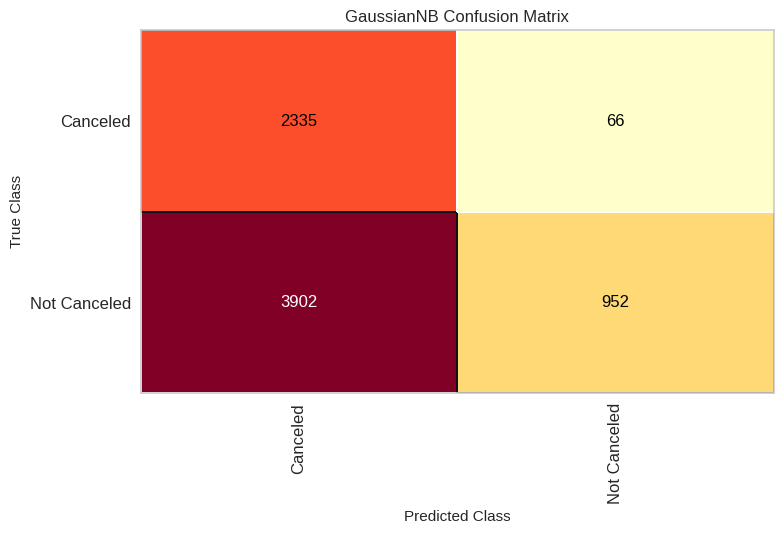

<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [15]:
cm = ConfusionMatrix(naive_bayes, classes=["Canceled", "Not Canceled"])
cm.fit(X_train, y_train)
score_naive_gaussian = cm.score(X_test, y_test)
print(score_naive_gaussian)
cm.show()

In [16]:
nb_unb_cross = []
for data in moredata:
    naive_bayes.fit(data["X_train"], data["y_train"])
    previsoes = naive_bayes.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    nb_unb_cross.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

Resultados de la primera ejecucion, relacionadas a la matriz de confusion

In [17]:
nb_unb_cross[0]

{'fp_rate': 0.803873094355171,
 'tp_rate': 0.9725114535610162,
 'tn_rate': 0.196126905644829,
 'fn_rate': 0.027488546438983758,
 'ga': 0.4530668504479669,
 'prec': 0.37437870771204107}

In [18]:
classification_naive_gaussian = (classification_report(y_test, previsoes))
print(classification_naive_gaussian)

              precision    recall  f1-score   support

           0       0.33      0.89      0.48      2401
           1       0.67      0.11      0.19      4854

    accuracy                           0.37      7255
   macro avg       0.50      0.50      0.34      7255
weighted avg       0.56      0.37      0.29      7255



In [19]:
# Curva ROC
y_prob = naive_bayes.predict_proba(X_test)[:, 1]
fpr_nbu, tpr_nbu, thresholds = roc_curve(y_test, y_prob)
auc_score_nbu = auc(fpr_nbu, tpr_nbu)

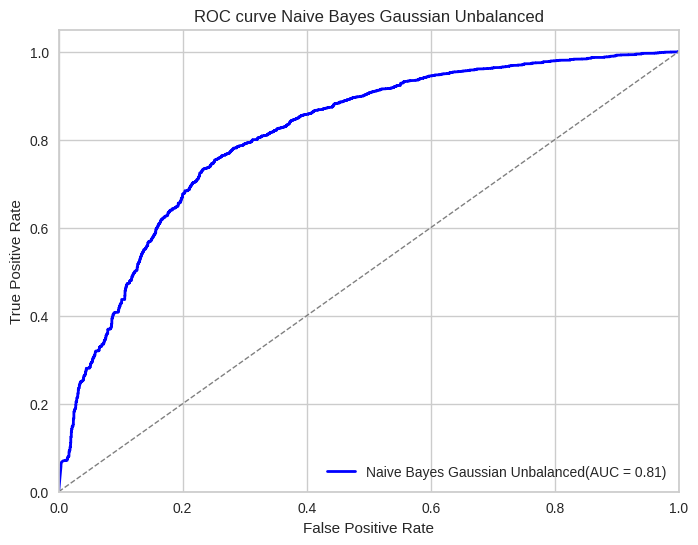

In [20]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
# plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Gaussian Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Naive Bayes Gaussian Unbalanced')
plt.legend(loc='lower right')
plt.show()

Ahora que se han hecho los calculos sin balancear, se balancean las clases.

Balancear las clases

En el EDA vimos que el dataset está desbalanceado. Hay una relación 2:1 entre las reservas no canceladas y las canceladas

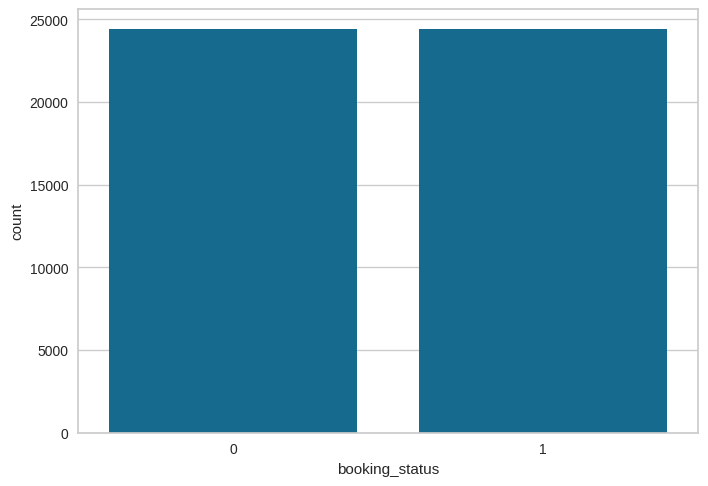

In [21]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)
ax = sns.countplot(x=y)

Cambiar las escalas

Se usa StandardScaler para poner toda la data en la misma escala

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

Guardar el CSV de la data limpia

In [24]:
X_df = pd.DataFrame(X, columns=df.columns.drop('booking_status'))
y_df = pd.DataFrame(y, columns=['booking_status'])

# Concatenar X e y de vuelta a un solo DataFrame
df_clean = pd.concat([X_df, y_df], axis=1)

df_clean.to_csv("set_Sebastian_Bustamante_clean.csv", index=False)

Transformar la data en entrenamiento y testeo, se va a usar el 20% de los datos para los testeos.

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Generar más datos para las demás pruebas

In [24]:
moredata = []
for i in range(10):
    X_train_temp,X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y, test_size = 0.2, random_state = i)
    moredata.append({"X_train": X_train_temp, "X_test": X_test_temp, "y_train": y_train_temp, "y_test": y_test_temp})

## Modelos a usar
Con el dataset ya limpio se pueden usar diferentes modelos

### Naive Bayes
Se usa el modelo de Naive Bayes, testeando el modelo Gaussiano con la data Normal

In [25]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
previsoes = naive_bayes.predict(X_test)

Resultados

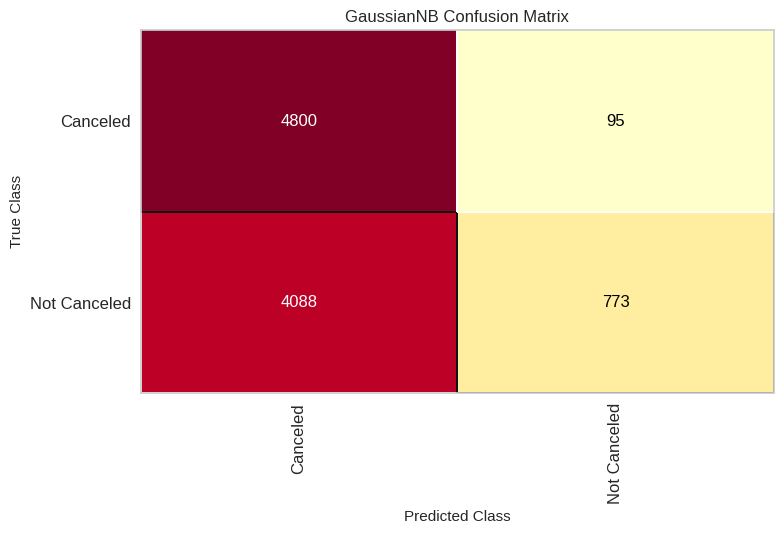

<Axes: title={'center': 'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [26]:
cm = ConfusionMatrix(naive_bayes,  classes=["Canceled", "Not Canceled"])
cm.fit(X_train, y_train)
score_naive_gaussian = cm.score(X_test, y_test)
score_naive_gaussian
cm.show()

In [27]:
classification_naive_gaussian = (classification_report(y_test, previsoes))
print(classification_naive_gaussian)

              precision    recall  f1-score   support

           0       0.54      0.98      0.70      4895
           1       0.89      0.16      0.27      4861

    accuracy                           0.57      9756
   macro avg       0.72      0.57      0.48      9756
weighted avg       0.71      0.57      0.48      9756



In [28]:
# Curva ROC
y_prob = naive_bayes.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, thresholds = roc_curve(y_test, y_prob)
auc_score_nb = auc(fpr_nb, tpr_nb)

Validacion cruzada

Ejecutar la prediccion 10 veces, con los datasets

In [29]:
nb_cross = []
for data in moredata:
    naive_bayes.fit(data["X_train"], data["y_train"])
    previsoes = naive_bayes.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    nb_cross.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

In [30]:
nb_cross[0]

{'fp_rate': 0.8409792223822259,
 'tp_rate': 0.9805924412665986,
 'tn_rate': 0.1590207776177741,
 'fn_rate': 0.01940755873340143,
 'ga': 0.5712382123821238,
 'prec': 0.54005400540054}

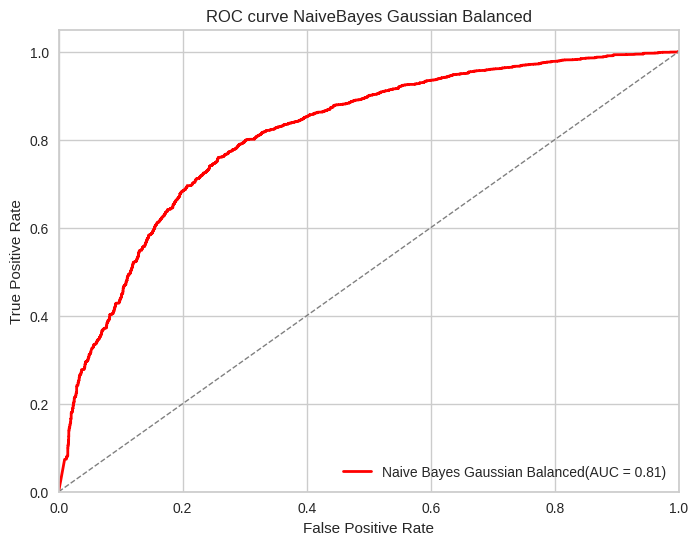

In [31]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Gaussian Balanced(AUC = %0.2f)' % auc_score_nb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve NaiveBayes Gaussian Balanced')
plt.legend(loc='lower right')
plt.show()

Naive Bayes con otra distribucion - BernoulliNB

In [32]:
from sklearn.naive_bayes import BernoulliNB

naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train)
previsoes = naive_bayes.predict(X_test)

0.7650676506765067


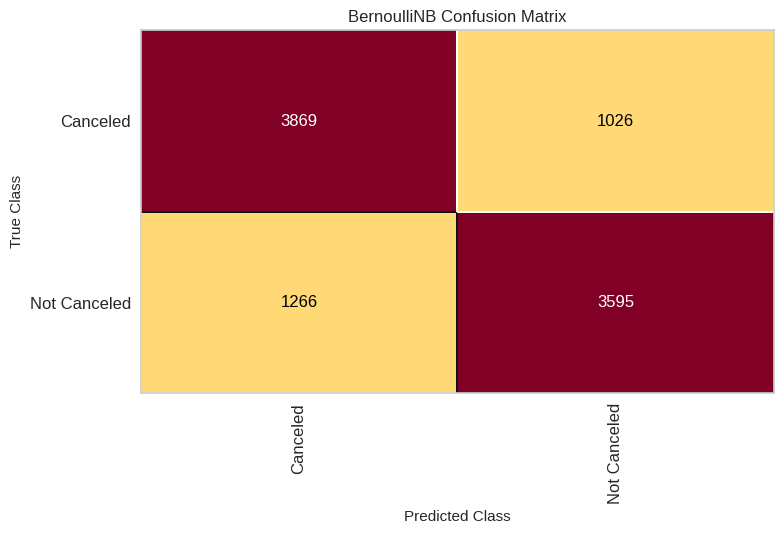

<Axes: title={'center': 'BernoulliNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [33]:
cm = ConfusionMatrix(naive_bayes,  classes=["Canceled", "Not Canceled"])
cm.fit(X_train, y_train)
score_naive_bernoulli = cm.score(X_test, y_test)
print(score_naive_bernoulli)
cm.show()

In [34]:
classification_naive_bernoulli = (classification_report(y_test, previsoes))
print(classification_naive_bernoulli)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4895
           1       0.78      0.74      0.76      4861

    accuracy                           0.77      9756
   macro avg       0.77      0.76      0.76      9756
weighted avg       0.77      0.77      0.76      9756



In [35]:
# Curva ROC
y_prob = naive_bayes.predict_proba(X_test)[:, 1]
fpr_nbb, tpr_nbb, thresholds = roc_curve(y_test, y_prob)
auc_score_nbb = auc(fpr_nbb, tpr_nbb)

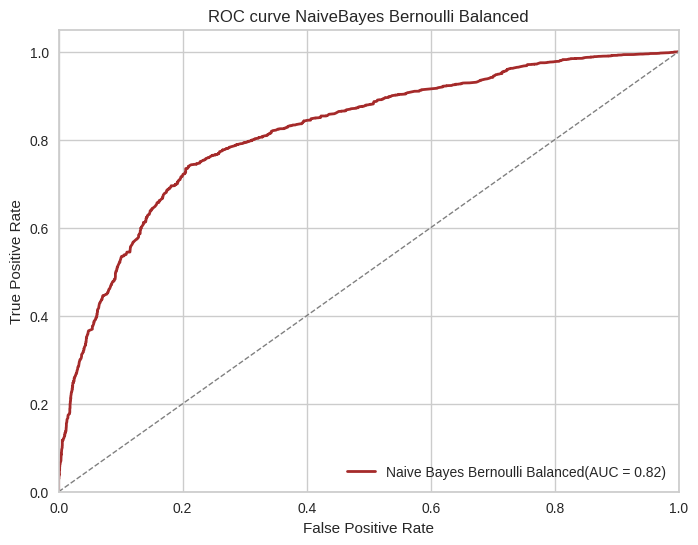

In [36]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
plt.plot(fpr_nbb, tpr_nbb, color='brown', lw=2, label='Naive Bayes Bernoulli Balanced(AUC = %0.2f)' % auc_score_nbb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve NaiveBayes Bernoulli Balanced')
plt.legend(loc='lower right')
plt.show()

Validacion cruzada

Ejecutar la prediccion 10 veces, con los datasets

In [37]:
nbb_cross = []
for data in moredata:
    naive_bayes.fit(data["X_train"], data["y_train"])
    previsoes = naive_bayes.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    nbb_cross.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

In [38]:
nbb_cross[0]

{'fp_rate': 0.26044023863402593,
 'tp_rate': 0.7903983656792646,
 'tn_rate': 0.7395597613659741,
 'fn_rate': 0.20960163432073545,
 'ga': 0.7650676506765067,
 'prec': 0.7534566699123662}

Comparacion de todos los NaiveBayes

In [39]:
sum_nb = process_metrics(cross_report(nb_cross))
sum_nb_u = process_metrics(cross_report(nb_unb_cross))
sum_nbb = process_metrics(cross_report(nbb_cross))

resume = pd.DataFrame({
    'Gaussian NaiveBayes - Balanced': pd.Series(sum_nb),
    'Gaussian NaiveBayes - Unbalanced':pd.Series(sum_nb_u),
    'Bernoulli NaiveBayes': pd.Series(sum_nbb),
})

In [40]:
resume

Gaussian NaiveBayes - Balanced  \
Global Accuracy                    0.5667 ± 0.0047   
True positive rate                 0.9820 ± 0.0018   
True negative rate                 0.1506 ± 0.0073   
False positive rate                0.8494 ± 0.0073   
False negative rate                0.0180 ± 0.0018   
Precision                          0.5367 ± 0.0043   

                    Gaussian NaiveBayes - Unbalanced Bernoulli NaiveBayes  
Global Accuracy                      0.4343 ± 0.0164      0.7608 ± 0.0032  
True positive rate                   0.9788 ± 0.0034      0.7821 ± 0.0059  
True negative rate                   0.1702 ± 0.0238      0.7394 ± 0.0063  
False positive rate                  0.8298 ± 0.0238      0.2606 ± 0.0063  
False negative rate                  0.0212 ± 0.0034      0.2179 ± 0.0059  
Precision                            0.3641 ± 0.0087      0.7504 ± 0.0057

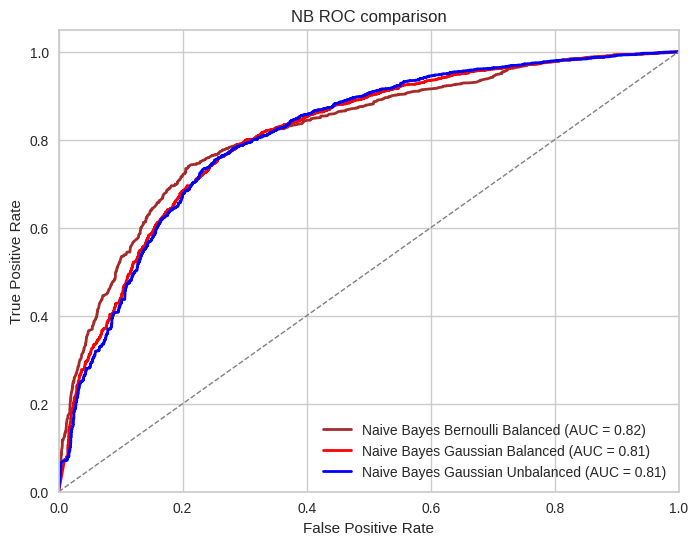

In [41]:
# Plot ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr_nbb, tpr_nbb, color='brown', lw=2, label='Naive Bayes Bernoulli Balanced (AUC = %0.2f)' % auc_score_nbb)
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Gaussian Balanced (AUC = %0.2f)' % auc_score_nb)
plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Gaussian Unbalanced (AUC = %0.2f)' % auc_score_nbu)

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NB ROC comparison')
plt.legend(loc='lower right')
plt.show()

### Árboles de decisiones
Árbol de decisión, testea Entropía y cálculos de Gini.
Usar GridSearch para revisar cuales son las mejores métricas para usar.


In [42]:
# min_split = np.array([2, 3, 4, 5, 6, 7])
# max_nvl = np.array([3, 4, 5, 6, 7, 9, 11])
# alg = ['entropy', 'gini']
# values_grid = {'min_samples_split': min_split, 'max_depth': max_nvl, 'criterion': alg}

# model = DecisionTreeClassifier()
# gridDecisionTree = GridSearchCV(estimator = model, param_grid = values_grid, cv = 5)
# gridDecisionTree.fit(X_train, y_train)

DecisionTree con GridSearch

In [43]:
# print('Mín Split: ', gridDecisionTree.best_estimator_.min_samples_split)
# print('Max Nvl: ', gridDecisionTree.best_estimator_.max_depth)
# print('Algorithm: ', gridDecisionTree.best_estimator_.criterion)
# print('Score: ', gridDecisionTree.best_score_)

Resultados de DecisionTree

In [44]:
decision_tree = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, max_depth= 11, random_state=0)
decision_tree.fit(X_train, y_train)
previsoes = decision_tree.predict(X_test)

0.8682861828618286


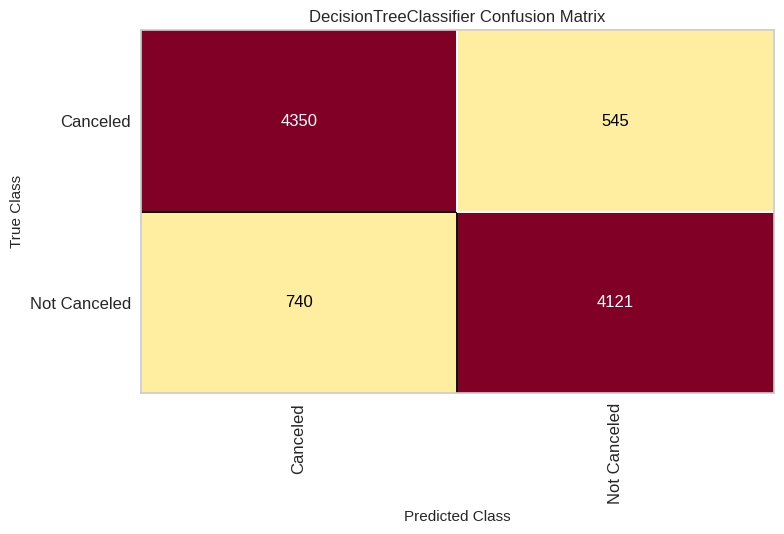

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [45]:
cm = ConfusionMatrix(decision_tree, classes=["Canceled", "Not Canceled"])
cm.fit(X_train, y_train)
score_tree = cm.score(X_test, y_test)
print(score_tree)
cm.show()

In [46]:
classification_decision = (classification_report(y_test, previsoes))
print(classification_decision)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4895
           1       0.88      0.85      0.87      4861

    accuracy                           0.87      9756
   macro avg       0.87      0.87      0.87      9756
weighted avg       0.87      0.87      0.87      9756



In [47]:
# Curva ROC
y_score = decision_tree.predict_proba(X_test)[:, 1]  # Use decision scores as probabilities
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_score)
auc_score_dt = auc(fpr_dt, tpr_dt)

In [48]:
dt_cross = []
# return tp_rate, fp_rate, tn_rate, fn_rate, ga, prec
for data in moredata:
    decision_tree.fit(data["X_train"], data["y_train"])
    previsoes = decision_tree.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    dt_cross.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

In [49]:
dt_cross[0]

{'fp_rate': 0.152232051018309,
 'tp_rate': 0.8886618998978549,
 'tn_rate': 0.847767948981691,
 'fn_rate': 0.11133810010214505,
 'ga': 0.8682861828618286,
 'prec': 0.8546168958742633}

Ver las variables mas importantes del modelo

In [50]:
columns = df.drop('booking_status', axis = 1).columns
feature_imp = pd.Series(decision_tree.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp

lead_time                               0.383149
market_segment_type                     0.153148
no_of_special_requests                  0.134130
avg_price_per_room                      0.104382
arrival_month                           0.074370
arrival_date                            0.035336
no_of_weekend_nights                    0.028589
no_of_adults                            0.027526
no_of_week_nights                       0.021416
arrival_year                            0.016450
required_car_parking_space              0.009428
type_of_meal_plan                       0.007555
room_type_reserved                      0.003386
repeated_guest                          0.000878
no_of_previous_cancellations            0.000256
no_of_children                          0.000000
no_of_previous_bookings_not_canceled    0.000000
dtype: float64

El árbol en sí

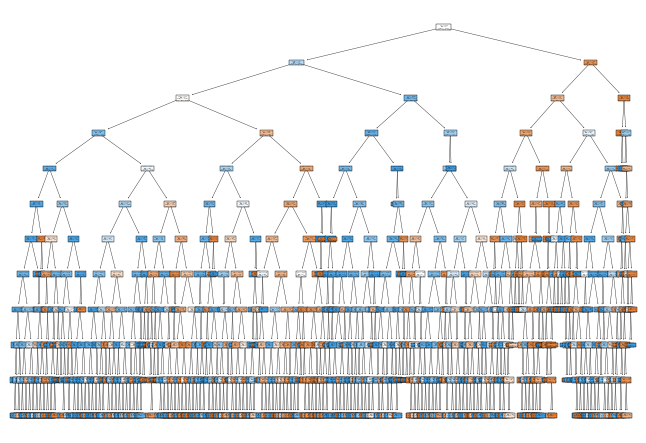

In [51]:
plot_tree(decision_tree, filled=True)
plt.show()

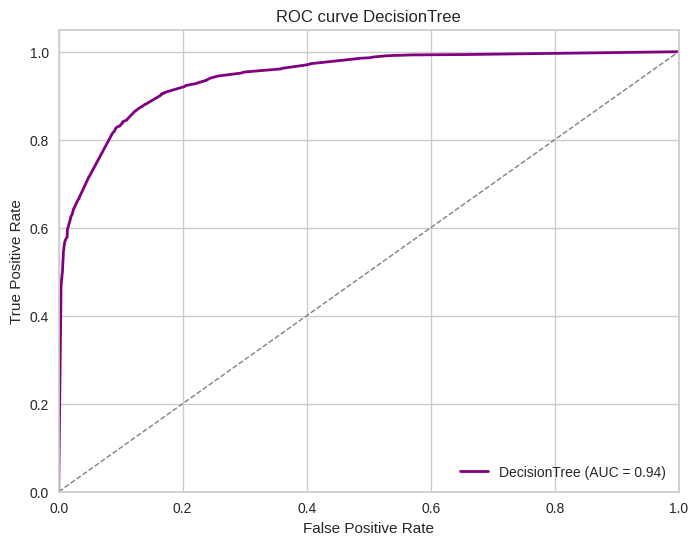

In [52]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
# plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve DecisionTree')
plt.legend(loc='lower right')
plt.show()

Arbol podado

In [53]:
decision_tree = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, max_depth= 2, random_state=0)

0.6935219352193522


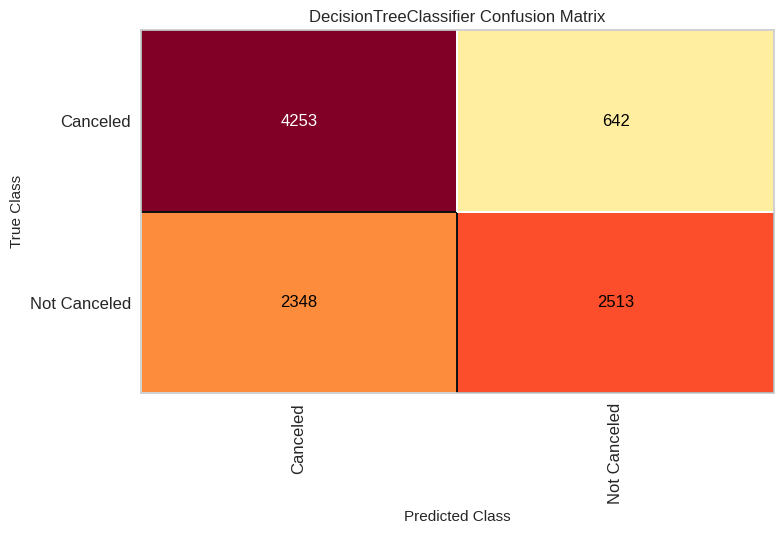

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [54]:
cm = ConfusionMatrix(decision_tree, classes=["Canceled", "Not Canceled"])
cm.fit(X_train, y_train)
score_tree = cm.score(X_test, y_test)
print(score_tree)
cm.show()

In [55]:
dt_cross_pod = []
# return tp_rate, fp_rate, tn_rate, fn_rate, ga, prec
for data in moredata:
    decision_tree.fit(data["X_train"], data["y_train"])
    previsoes = decision_tree.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    dt_cross_pod.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

In [56]:
dt_cross_pod[0]

{'fp_rate': 0.4830281835013372,
 'tp_rate': 0.8688457609805924,
 'tn_rate': 0.5169718164986629,
 'fn_rate': 0.13115423901940756,
 'ga': 0.6935219352193522,
 'prec': 0.6442963187395849}

In [57]:
# Curva ROC
y_score = decision_tree.predict_proba(X_test)[:, 1]  # Use decision scores as probabilities
fpr_dtp, tpr_dtp, thresholds = roc_curve(y_test, y_score)
auc_score_dtp = auc(fpr_dtp, tpr_dtp)

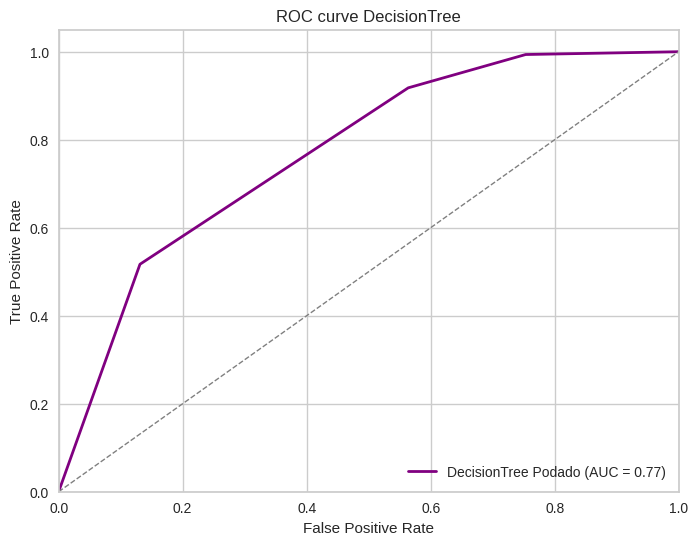

In [58]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtp, tpr_dtp, color='purple', lw=2, label='DecisionTree Podado (AUC = %0.2f)' % auc_score_dtp)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
# plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve DecisionTree')
plt.legend(loc='lower right')
plt.show()

comparativa de DT podado y no podado

In [59]:
sum_dt_pod = process_metrics(cross_report(dt_cross_pod))
sum_dt = process_metrics(cross_report(dt_cross))

resume = pd.DataFrame({
    'DecisionTree D11': pd.Series(sum_dt),
    'DecisionTree D3':pd.Series(sum_dt_pod),
})

In [60]:
resume

DecisionTree D11  DecisionTree D3
Global Accuracy      0.8684 ± 0.0032  0.6809 ± 0.0047
True positive rate   0.8670 ± 0.0104  0.8615 ± 0.0060
True negative rate   0.8697 ± 0.0094  0.4999 ± 0.0073
False positive rate  0.1303 ± 0.0094  0.5001 ± 0.0073
False negative rate  0.1330 ± 0.0104  0.1385 ± 0.0060
Precision            0.8697 ± 0.0071  0.6332 ± 0.0048

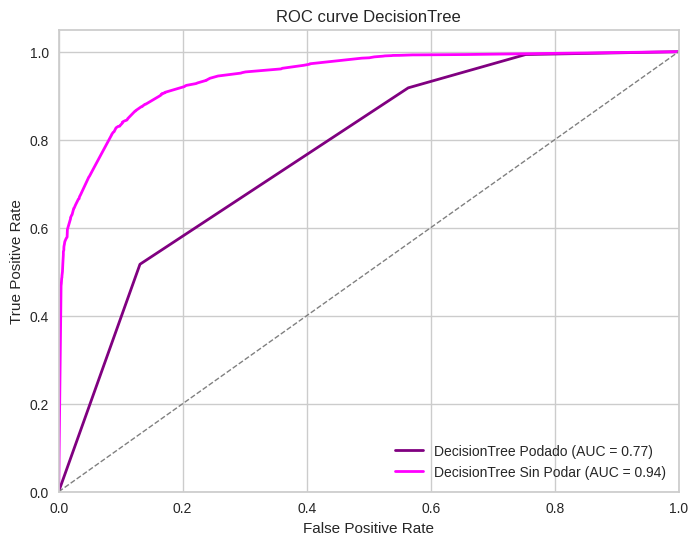

In [61]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtp, tpr_dtp, color='purple', lw=2, label='DecisionTree Podado (AUC = %0.2f)' % auc_score_dtp)
plt.plot(fpr_dt, tpr_dt, color='magenta', lw=2, label='DecisionTree Sin Podar (AUC = %0.2f)' % auc_score_dt)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
# plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve DecisionTree')
plt.legend(loc='lower right')
plt.show()

### RandomForest
Se usa el modelo de RandomForest con cálculos de Entropía y Gini

Aplicar GridSearch

In [62]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators = np.array([100])
# alg = ['entropy', 'gini']
# min_split = np.array([2, 3, 4, 5, 6, 7])
# max_nvl = np.array([3, 4, 5, 6, 7, 9, 11])
# values_grid = {'n_estimators': n_estimators, 'min_samples_split': min_split, 'max_depth': max_nvl, 'criterion': alg}

# model = RandomForestClassifier()

In [63]:
# gridRandomForest = GridSearchCV(estimator = model, param_grid = values_grid, cv = 5)
# gridRandomForest.fit(X_train, y_train)

RandomForest con GridSearch

In [64]:
# print(gridRandomForest.best_params_)

In [65]:
# print('Algorithm: ', gridRandomForest.best_estimator_.criterion)
# print('Score: ', gridRandomForest.best_score_)
# print('Mín Split: ', gridRandomForest.best_estimator_.min_samples_split)
# print('Max Nvl: ', gridRandomForest.best_estimator_.max_depth)

Ejecutar RandomForest

In [66]:
random_forest = RandomForestClassifier(n_estimators = 100, min_samples_split = 2, max_depth= 11,  criterion = 'gini', random_state = 0)
random_forest.fit(X_train, y_train)
previsoes = random_forest.predict(X_test)

Resultados

0.8763837638376384


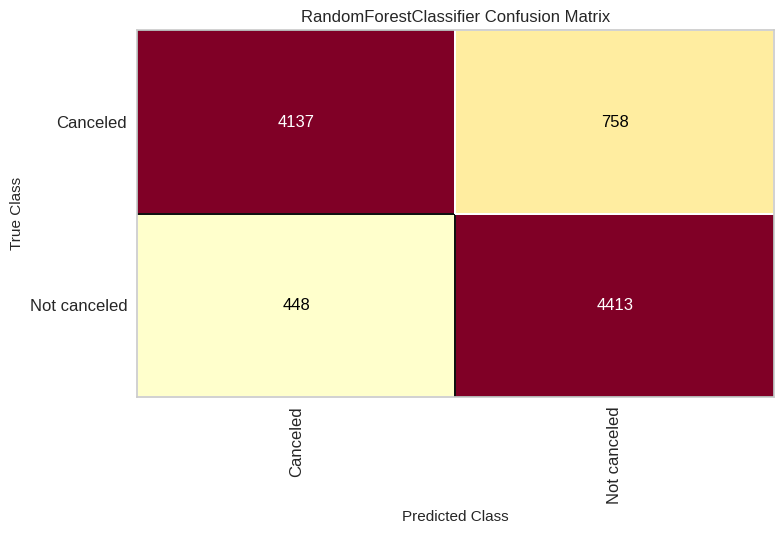

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [67]:
cm = ConfusionMatrix(random_forest, classes=["Canceled", "Not canceled"])
cm.fit(X_train, y_train)
score_random = cm.score(X_test, y_test)
print(score_random)
cm.show()

In [68]:
# Curva ROC
y_score = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_score)
auc_score_rf = auc(fpr_rf, tpr_rf)

In [69]:
rf_cross = []
for data in moredata:
    random_forest.fit(data["X_train"], data["y_train"])
    previsoes = random_forest.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    rf_cross.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

In [70]:
rf_cross[0]

{'fp_rate': 0.09216210656243572,
 'tp_rate': 0.8451481103166496,
 'tn_rate': 0.9078378934375643,
 'fn_rate': 0.15485188968335037,
 'ga': 0.8763837638376384,
 'prec': 0.9022900763358779}

In [71]:
classification_random = (classification_report(y_test, previsoes))
print(classification_random)

              precision    recall  f1-score   support

           0       0.50      0.46      0.48      4895
           1       0.50      0.54      0.52      4861

    accuracy                           0.50      9756
   macro avg       0.50      0.50      0.50      9756
weighted avg       0.50      0.50      0.50      9756



Revisar las variables más importantes del modelo

In [72]:
feature_imp_random = pd.Series(random_forest.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp_random

lead_time                               0.364339
no_of_special_requests                  0.166087
avg_price_per_room                      0.105086
market_segment_type                     0.102367
arrival_month                           0.070974
arrival_year                            0.045373
arrival_date                            0.032036
no_of_weekend_nights                    0.024192
no_of_week_nights                       0.023544
no_of_adults                            0.016954
type_of_meal_plan                       0.014837
required_car_parking_space              0.011091
room_type_reserved                      0.009964
no_of_previous_bookings_not_canceled    0.004722
repeated_guest                          0.004484
no_of_children                          0.003500
no_of_previous_cancellations            0.000450
dtype: float64

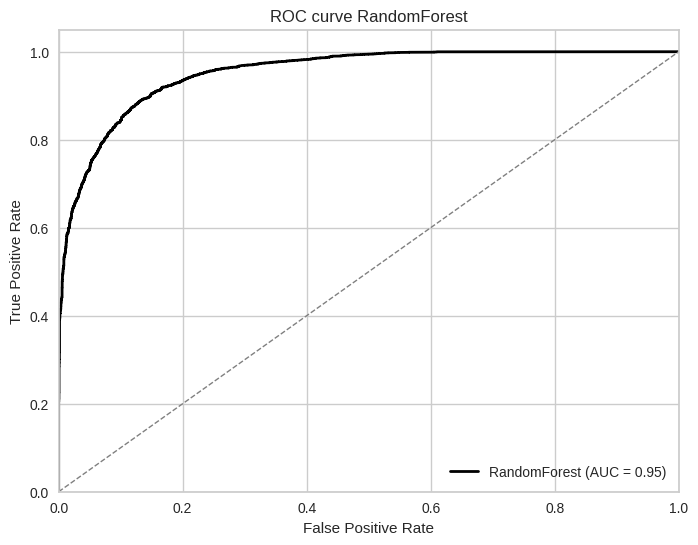

In [73]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
# plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve RandomForest')
plt.legend(loc='lower right')
plt.show()

ejecucion con 10, 20, 50, 100, 200, 500 arboles

In [74]:
ntrees = [10, 20, 50, 100, 200, 500]
rf_crosses = []
for n in ntrees:
    random_forest = RandomForestClassifier(n_estimators = n, min_samples_split = 2, max_depth= 11,  criterion = 'gini', random_state = 0)
    rf_c = []
    for data in moredata:
        random_forest.fit(data["X_train"], data["y_train"])
        previsoes = random_forest.predict(data["X_test"])
        tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
        rf_c.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})
    rf_crosses.append(rf_c)
    

In [75]:
rf_mean_scores = []
rf_std_scores = []
for cross in rf_crosses:
    tlist = []
    for ex in cross:
        tlist.append(ex["ga"])
    rf_mean_scores.append(np.mean(tlist))
    rf_std_scores.append(np.std(tlist))

graficar scores vs n de arboles


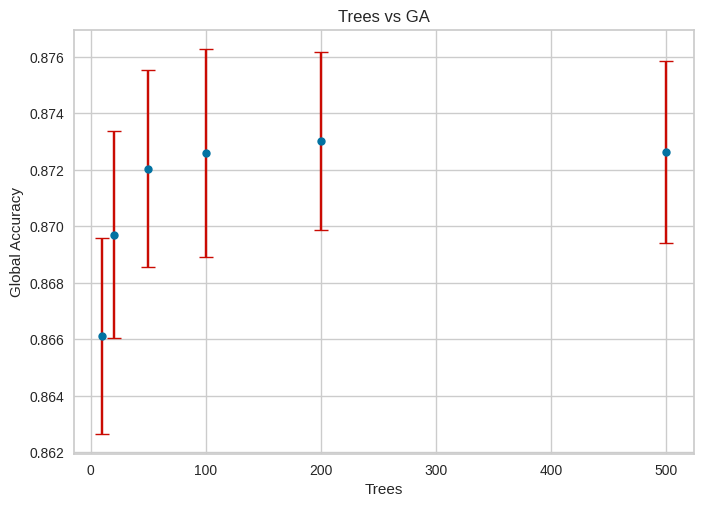

In [76]:
#plt.plot(ntrees, rf_mean_scores, linestyle='-', color='r', marker='o')

plt.errorbar(ntrees, rf_mean_scores, yerr=rf_std_scores, ecolor='r', capsize=5, capthick=2, linestyle='None', marker='o', markersize=5, markeredgewidth=1)

# Add titles and labels
plt.title("Trees vs GA")
plt.xlabel("Trees")
plt.ylabel("Global Accuracy")

# Show the plot
plt.show()

### K Neighbors
KNN con GridSearch para buscar las mejores metricas para el modelo

Usar GridSearch

In [77]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

k_list = list(range(1,10))
# k_values = dict(n_neighbors = k_list)


In [78]:
# grid = GridSearchCV(knn, k_values, cv = 2, scoring = 'accuracy', n_jobs = -1)
# grid.fit(X_train, y_train)

KNN con GridSearch

In [79]:
# grid.best_params_, grid.best_score_

Ejecutar KNN

In [80]:
# Ojo que se tiene n=1! Estos parametros fueron determinados con la gridsearch
knn = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
previsoes = knn.predict(X_test)

Resultados

0.9074415744157441


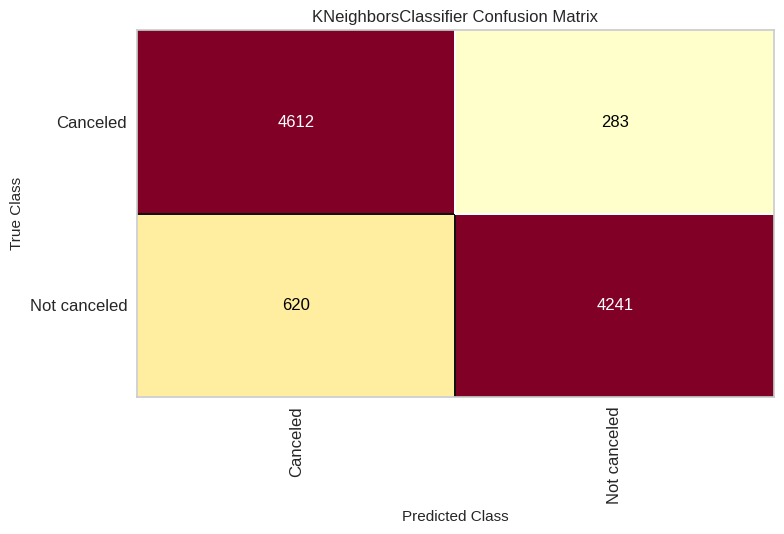

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [81]:
cm = ConfusionMatrix(knn, classes=["Canceled", "Not canceled"])
cm.fit(X_train, y_train)
score_knn = cm.score(X_test, y_test)
print(score_knn)
cm.show()

In [82]:
classification_knn = (classification_report(y_test, previsoes))
print(classification_knn)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4895
           1       0.94      0.87      0.90      4861

    accuracy                           0.91      9756
   macro avg       0.91      0.91      0.91      9756
weighted avg       0.91      0.91      0.91      9756



In [83]:
y_score = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_score)
auc_score_knn = auc(fpr_knn, tpr_knn)

In [84]:
knn_cross = []
for data in moredata:
    knn.fit(data["X_train"], data["y_train"])
    previsoes = knn.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    knn_cross.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

In [85]:
knn_cross[0]

{'fp_rate': 0.12754577247479942,
 'tp_rate': 0.9421859039836568,
 'tn_rate': 0.8724542275252005,
 'fn_rate': 0.05781409601634321,
 'ga': 0.9074415744157441,
 'prec': 0.8814984709480123}

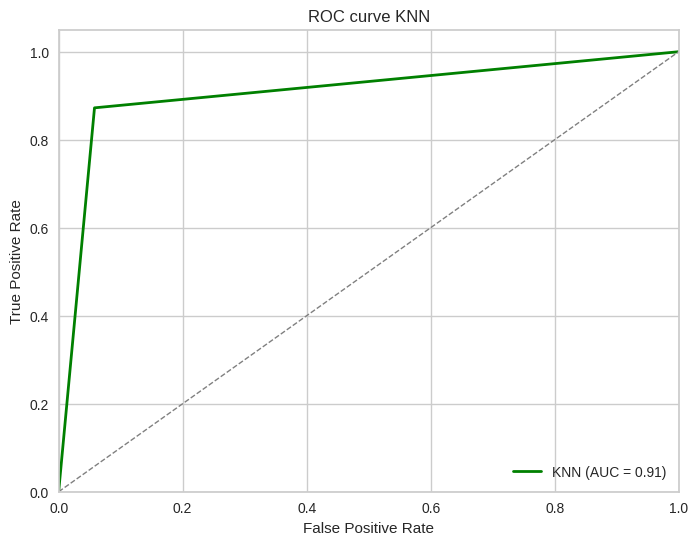

In [86]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
# plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
# plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve KNN')
plt.legend(loc='lower right')
plt.show()

generar 10 validaciones cruzadas con KNN

In [87]:
knn_crosses = []
for i in range(20):
    knn = KNeighborsClassifier(n_neighbors = i+1, metric = 'minkowski', p = 2)
    knn_c = []
    for data in moredata:
        knn.fit(data["X_train"], data["y_train"])
        previsoes = knn.predict(data["X_test"])
        tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
        knn_c.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})
    knn_crosses.append(knn_c)

graficar todos los GA vs el numero de knn

In [88]:
ns = [i+1 for i in range(20)]
knn_mean_gas = []
knn_mean_fprs = []
knn_gas_stds = []
knn_fpr_stds = []
for cross in knn_crosses:
    tlist1 = []
    tlist2 = []
    for ex in cross:
        tlist1.append(ex["ga"])
        tlist2.append(ex["fp_rate"])
    knn_gas_stds.append(np.std(tlist1))
    knn_fpr_stds.append(np.std(tlist2))
    knn_mean_gas.append(np.mean(tlist1))
    knn_mean_fprs.append(np.mean(tlist2))
print(len(knn_mean_gas))

20


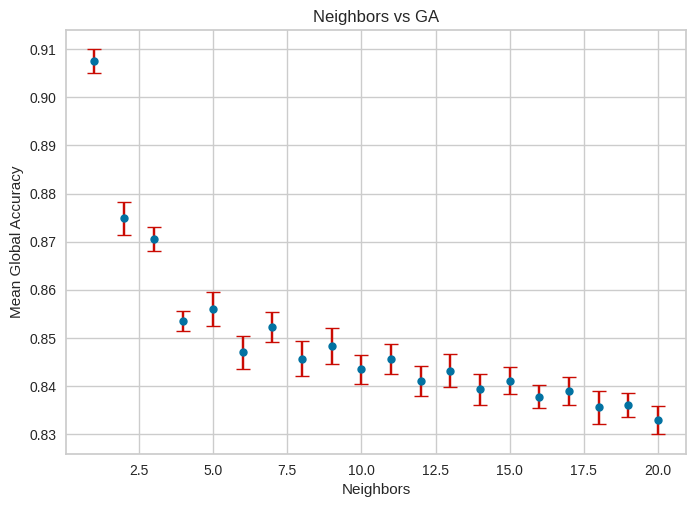

In [89]:
plt.errorbar(ns, knn_mean_gas, yerr=knn_gas_stds, ecolor='r', capsize=5, capthick=2, linestyle='None', marker='o', markersize=5, markeredgewidth=1)

# Add titles and labels
plt.title("Neighbors vs GA")
plt.xlabel("Neighbors")
plt.ylabel("Mean Global Accuracy")

# Show the plot
plt.show()

In [90]:
#plt.plot(ns, knn_mean_fprs, linestyle='-', color='r', marker='o')
plt.errorbar(ns, knn_mean_fprs, yerr=knn_fpr_stds, ecolor='r', capsize=5, capthick=2, linestyle='None', marker='o', markersize=5, markeredgewidth=1)

# Add titles and labels
plt.title("Neighbors vs FPR")
plt.xlabel("Neighbors")
plt.ylabel("Mean False positive rate")

# Show the plot
plt.show()

SVM

Se usa máquina de vectores de soporte también para hacer la clasificación

In [91]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

previsoes = clf.predict(X_test)

In [92]:
cm = ConfusionMatrix(clf, classes=["Canceled", "Not canceled"])
cm.fit(X_train, y_train)
score_clf = cm.score(X_test, y_test)
print(score_clf)
cm.show()

0.7803403034030341


<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [93]:
# clf = svm.SVC(kernel='linear', probability=True)
# clf.fit(X_train, y_train)
# y_score = clf.predict_proba(X_test)[:, 1]
# fpr_svm, tpr_svm, thresholds = roc_curve(y_test, y_score)
# auc_score_svm = auc(fpr_svm, tpr_svm)

In [94]:
svm_cross = []
for data in moredata:
    clf.fit(data["X_train"], data["y_train"])
    previsoes = clf.predict(data["X_test"])
    tp_rate, fp_rate, tn_rate, fn_rate, ga, prec = get_tp_fp(data["y_test"], previsoes)
    svm_cross.append({"fp_rate":fp_rate, "tp_rate":tp_rate, "tn_rate":tn_rate, "fn_rate":fn_rate, "ga":ga, "prec":prec})

In [95]:
svm_cross[0]

{'fp_rate': 0.23205101830898991,
 'tp_rate': 0.7926455566905005,
 'tn_rate': 0.7679489816910101,
 'fn_rate': 0.20735444330949948,
 'ga': 0.7803403034030341,
 'prec': 0.7747603833865815}

In [96]:
classification_clf = (classification_report(y_test, previsoes))
print(classification_knn)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4895
           1       0.94      0.87      0.90      4861

    accuracy                           0.91      9756
   macro avg       0.91      0.91      0.91      9756
weighted avg       0.91      0.91      0.91      9756



In [97]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
# plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
# plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
# plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
# plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve SVM')
plt.legend(loc='lower right')
plt.show()

NameError: name 'fpr_svm' is not defined

<Figure size 800x600 with 0 Axes>

Curva ROC comparacion de todos los modelos

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='DecisionTree (AUC = %0.2f)' % auc_score_dt)
plt.plot(fpr_rf, tpr_rf, color='black', lw=2, label='RandomForest (AUC = %0.2f)' % auc_score_rf)
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % auc_score_knn)
plt.plot(fpr_svm, tpr_svm, color='orange', lw=2, label='SVM (AUC = %0.2f)' % auc_score_svm)
plt.plot(fpr_nbb, tpr_nbb, color='lightgreen', lw=2, label='Naive Bayes Bernoulli(AUC = %0.2f)' % auc_score_nbb)
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label='Naive Bayes Balanced(AUC = %0.2f)' % auc_score_nb)
plt.plot(fpr_nbu, tpr_nbu, color='blue', lw=2, label='Naive Bayes Unbalanced(AUC = %0.2f)' % auc_score_nbu)
plt.plot(fpr_dtp, tpr_dtp, color='magenta', lw=2, label='DecisionTree Podado (AUC = %0.2f)' % auc_score_dtp)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC comparison')
plt.legend(loc='lower right')
plt.show()

In [98]:
feature_imp

lead_time                               0.383149
market_segment_type                     0.153148
no_of_special_requests                  0.134130
avg_price_per_room                      0.104382
arrival_month                           0.074370
arrival_date                            0.035336
no_of_weekend_nights                    0.028589
no_of_adults                            0.027526
no_of_week_nights                       0.021416
arrival_year                            0.016450
required_car_parking_space              0.009428
type_of_meal_plan                       0.007555
room_type_reserved                      0.003386
repeated_guest                          0.000878
no_of_previous_cancellations            0.000256
no_of_children                          0.000000
no_of_previous_bookings_not_canceled    0.000000
dtype: float64

In [ ]:
feature_imp_random

lead_time                               0.364339
no_of_special_requests                  0.166087
avg_price_per_room                      0.105086
market_segment_type                     0.102367
arrival_month                           0.070974
arrival_year                            0.045373
arrival_date                            0.032036
no_of_weekend_nights                    0.024192
no_of_week_nights                       0.023544
no_of_adults                            0.016954
type_of_meal_plan                       0.014837
required_car_parking_space              0.011091
room_type_reserved                      0.009964
no_of_previous_bookings_not_canceled    0.004722
repeated_guest                          0.004484
no_of_children                          0.003500
no_of_previous_cancellations            0.000450
dtype: float64

In [ ]:
Naive_dict_v1 = {'Model':'Naive Bayes',
               'Scaling':'Normal Data',
               'Type':'Gaussian',
               'Global Accuracy':score_naive_gaussian}

Decision_dict = {'Model':'Decision Tree',
               'Scaling':'Normal Data',
               'Type': 'Gini',
               'Global Accuracy':score_tree}

Random_dict = {'Model':'Random Forest',
               'Scaling':'Normal Data',
               'Type': 'Gini',
               'Precision':score_random}

KNN_dict_v2 = {'Model':'KNN',
               'Scaling':'Normal',
               'Type':'-',
               'Precision':score_knn}

SVM_dict = { 'Model':'SVM',
             'Scaling':'Normal',
             'Type':'Linear',
             'Precision':score_clf}


In [ ]:
resume = pd.DataFrame({'Naive Bayes Balanced':pd.Series(Naive_dict_v1),
                       'Decision Tree':pd.Series(Decision_dict),
                       'Random Forest':pd.Series(Random_dict),
                       'KNN':pd.Series(KNN_dict_v2),
                       'SVM': pd.Series(SVM_dict),
                      })

In [ ]:
resume

Naive Bayes Balanced  Decision Tree  Random Forest       KNN  \
Global Accuracy             0.571238       0.868286            NaN       NaN   
Model                    Naive Bayes  Decision Tree  Random Forest       KNN   
Precision                        NaN            NaN       0.876384  0.907442   
Scaling                  Normal Data    Normal Data    Normal Data    Normal   
Type                        Gaussian           Gini           Gini         -   

                     SVM  
Global Accuracy      NaN  
Model                SVM  
Precision        0.78034  
Scaling           Normal  
Type              Linear

In [101]:
sum_nb = process_metrics(cross_report(nb_cross))
sum_nbu = process_metrics(cross_report(nb_unb_cross))
sum_nbb = process_metrics(cross_report(nbb_cross))
sum_knn = process_metrics(cross_report(knn_cross))
sum_svm = process_metrics(cross_report(svm_cross))
sum_rf = process_metrics(cross_report(rf_cross))
sum_dt = process_metrics(cross_report(dt_cross))

resume = pd.DataFrame({
    'Gaussian NB Balanced': pd.Series(sum_nb),
    'Bernoulli NB': pd.Series(sum_nbb),
    'Gaussian NB Unbalanced': pd.Series(sum_nbu),
    'DecisionTree': pd.Series(sum_dt),
    'RandomForest': pd.Series(sum_rf),
    'KNN': pd.Series(sum_knn),
    'SVM': pd.Series(sum_svm),
})

In [102]:
resume

Gaussian NB Balanced     Bernoulli NB  \
Global Accuracy          0.5667 ± 0.0047  0.7608 ± 0.0032   
True positive rate       0.9820 ± 0.0018  0.7821 ± 0.0059   
True negative rate       0.1506 ± 0.0073  0.7394 ± 0.0063   
False positive rate      0.8494 ± 0.0073  0.2606 ± 0.0063   
False negative rate      0.0180 ± 0.0018  0.2179 ± 0.0059   
Precision                0.5367 ± 0.0043  0.7504 ± 0.0057   

                    Gaussian NB Unbalanced     DecisionTree     RandomForest  \
Global Accuracy            0.4343 ± 0.0164  0.8684 ± 0.0032  0.8726 ± 0.0037   
True positive rate         0.9788 ± 0.0034  0.8670 ± 0.0104  0.8352 ± 0.0078   
True negative rate         0.1702 ± 0.0238  0.8697 ± 0.0094  0.9101 ± 0.0033   
False positive rate        0.8298 ± 0.0238  0.1303 ± 0.0094  0.0899 ± 0.0033   
False negative rate        0.0212 ± 0.0034  0.1330 ± 0.0104  0.1648 ± 0.0078   
Precision                  0.3641 ± 0.0087  0.8697 ± 0.0071  0.9029 ± 0.0040   

                                 KNN              SVM  
Global Accuracy      0.9074 ± 0.0025  0.7780 ± 0.0023  
True positive rate   0.9385 ± 0.0036  0.7827 ± 0.0047  
True negative rate   0.8763 ± 0.0047  0.7732 ± 0.0048  
False positive rate  0.1237 ± 0.0047  0.2268 ± 0.0048  
False negative rate  0.0615 ± 0.0036  0.2173 ± 0.0047  
Precision            0.8837 ± 0.0043  0.7757 ± 0.0046